# Sign Language Detection

## **About Dataset**
 The dataset encompasses a all the English alphabet letters, providing extensive coverage for American Sign Language (ASL) gestures. Size of training dataset is 12875. Size of testing dataset is 4268.<br>

**Dataset Source**<br>
1. [Training Dataset](https://drive.google.com/drive/u/0/folders/1-XTAjPPRPFeRqu3848z8dMXaolILWizn)<br>
2. [Testing Dataset](https://drive.google.com/drive/u/0/folders/18e1F1n1SWPF8lUF8pCKdUzSzKAbmSbVN)

## **About Project**
This project focuses on classifying any image into one of the 26 alphabets of English language. We have used **Transfer Learning**. Pre-trained model used is **VGG16**.

## Importing Libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras import models, layers
from keras.optimizers import Adam
import cv2
from keras.callbacks import ModelCheckpoint
import random

## Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


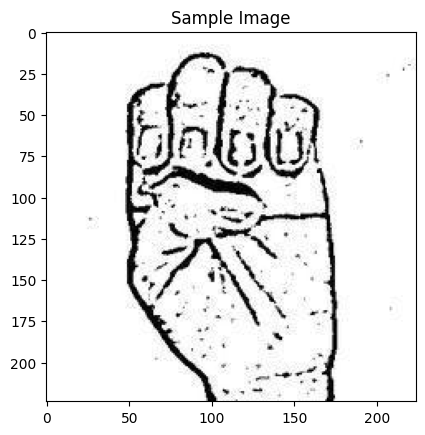

In [4]:
# Sample Image
image_path = '/content/drive/MyDrive/sign_language_dataset/train/E/101.jpg'
img = mpimg.imread(image_path)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.show()

In [ ]:
img.shape

(310, 310)

### Resizing<br>
The image size now is (310, 310) but the VGG16 model works best for image size of (224, 224). So all the images have to be resized.

In [5]:
train_dir = '/content/drive/MyDrive/sign_language_dataset/train'
test_dir = '/content/drive/MyDrive/sign_language_dataset/test'

In [ ]:
target_size = (224, 224)

def resize_images(directory):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                image = Image.open(image_path)
                resized_image = image.resize(target_size, Image.ANTIALIAS)
                resized_image.save(image_path)

resize_images(train_dir)
resize_images(test_dir)

<ipython-input-8-e8cbf5dda33d>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [7]:
image_path = '/content/drive/MyDrive/sign_language_dataset/train/E/101.jpg'
img = mpimg.imread(image_path)
img.shape

(224, 224)

### Creating Dataframes

In [8]:
train_data = []
test_data = []

def get_data(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                data.append({'label': label, 'path': image_path})
    return data

In [9]:
train_df = pd.DataFrame(get_data(train_dir))
test_df = pd.DataFrame(get_data(test_dir))

In [10]:
train_df.head()

,label,path
0,Z,/content/drive/MyDrive/sign_language_dataset/t...
1,Z,/content/drive/MyDrive/sign_language_dataset/t...
2,Z,/content/drive/MyDrive/sign_language_dataset/t...
3,Z,/content/drive/MyDrive/sign_language_dataset/t...
4,Z,/content/drive/MyDrive/sign_language_dataset/t...


In [11]:
train_df['label'].unique()

array(['Z', 'Y', 'Q', 'T', 'R', 'X', 'U', 'V', 'S', 'W', 'G', 'H', 'M',
       'O', 'I', 'L', 'J', 'N', 'P', 'K', 'C', 'A', 'E', 'D', 'F', 'B',
       '0'], dtype=object)

In [12]:
train_df.shape

(12875, 2)

In [13]:
test_df.head()

,label,path
0,Z,/content/drive/MyDrive/sign_language_dataset/t...
1,Z,/content/drive/MyDrive/sign_language_dataset/t...
2,Z,/content/drive/MyDrive/sign_language_dataset/t...
3,Z,/content/drive/MyDrive/sign_language_dataset/t...
4,Z,/content/drive/MyDrive/sign_language_dataset/t...


In [14]:
test_df['label'].unique()

array(['Z', 'Y', 'X', 'P', 'W', 'O', 'S', 'R', 'Q', 'V', 'T', 'U', 'N',
       'M', 'K', 'H', 'E', 'G', 'J', 'D', 'I', 'L', 'F', 'C', 'B', '0',
       'A'], dtype=object)

## Modelling

In [15]:
img_width, img_height = 224, 224
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(train_df[y_col].unique())

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/sign_language_dataset/train",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 12875 files belonging to 27 classes.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/sign_language_dataset/test",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 4268 files belonging to 27 classes.


In [18]:
# Immutable base model
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01),activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
# dense_layer_2 = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),activation='relu')
# dense_layer_3 = layers.Dense(264, kernel_regularizer=regularizers.l2(0.01),activation='relu')
prediction_layer = layers.Dense(27, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    # dense_layer_2,
    # dense_layer_3,
    prediction_layer
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                                 
Total params: 27574107 (105.19 MB)
Trainable params: 12859419 (49.05 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
classes = 27
epochs = 15
learning_rate = 0.0001

adam = Adam(learning_rate=learning_rate)

In [22]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds,shuffle=True)

Epoch 1/15
93/93 [==============================] - 112s 933ms/step - loss: 8.2029 - accuracy: 0.9201 - val_loss: 5.9421 - val_accuracy: 0.9637
Epoch 2/15
93/93 [==============================] - 69s 729ms/step - loss: 4.7041 - accuracy: 0.9971 - val_loss: 4.7749 - val_accuracy: 0.9637
Epoch 3/15
93/93 [==============================] - 70s 742ms/step - loss: 3.8657 - accuracy: 0.9979 - val_loss: 4.0747 - val_accuracy: 0.9637
Epoch 4/15
93/93 [==============================] - 70s 736ms/step - loss: 3.3281 - accuracy: 0.9987 - val_loss: 3.6996 - val_accuracy: 0.9635
Epoch 5/15
93/93 [==============================] - 70s 739ms/step - loss: 2.9002 - accuracy: 0.9985 - val_loss: 3.3476 - val_accuracy: 0.9637
Epoch 6/15
93/93 [==============================] - 69s 734ms/step - loss: 2.5435 - accuracy: 0.9989 - val_loss: 2.9305 - val_accuracy: 0.9637
Epoch 7/15
93/93 [==============================] - 1091s 12s/step - loss: 2.2409 - accuracy: 0.9989 - val_loss: 2.5857 - val_accuracy: 0.963

In [ ]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

34/34 [==============================] - 689s 15s/step - loss: 1.5117 - accuracy: 0.9637
Test Loss: 1.5117027759552002, Test Accuracy: 96.36832475662231%


## Plotting Accuracy

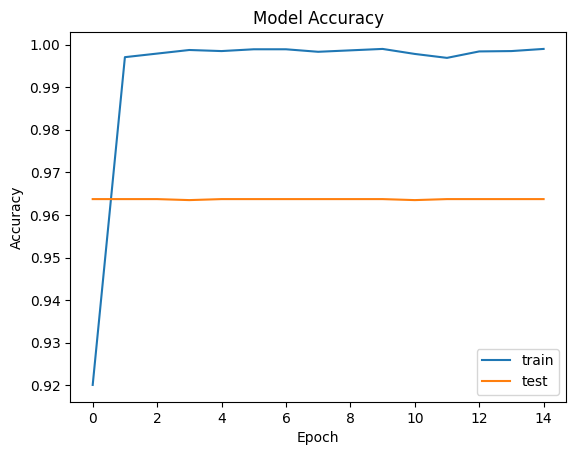

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

## Testing

In [ ]:
img = cv2.imread("/content/drive/MyDrive/saidataset/test/F/121.jpg")
img = np.expand_dims(img, 0)

In [ ]:
pred = model.predict(img)

1/1 [==============================] - 0s 35ms/step


In [ ]:
train_ds.class_names[np.argmax(pred[0])]

'F'

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step


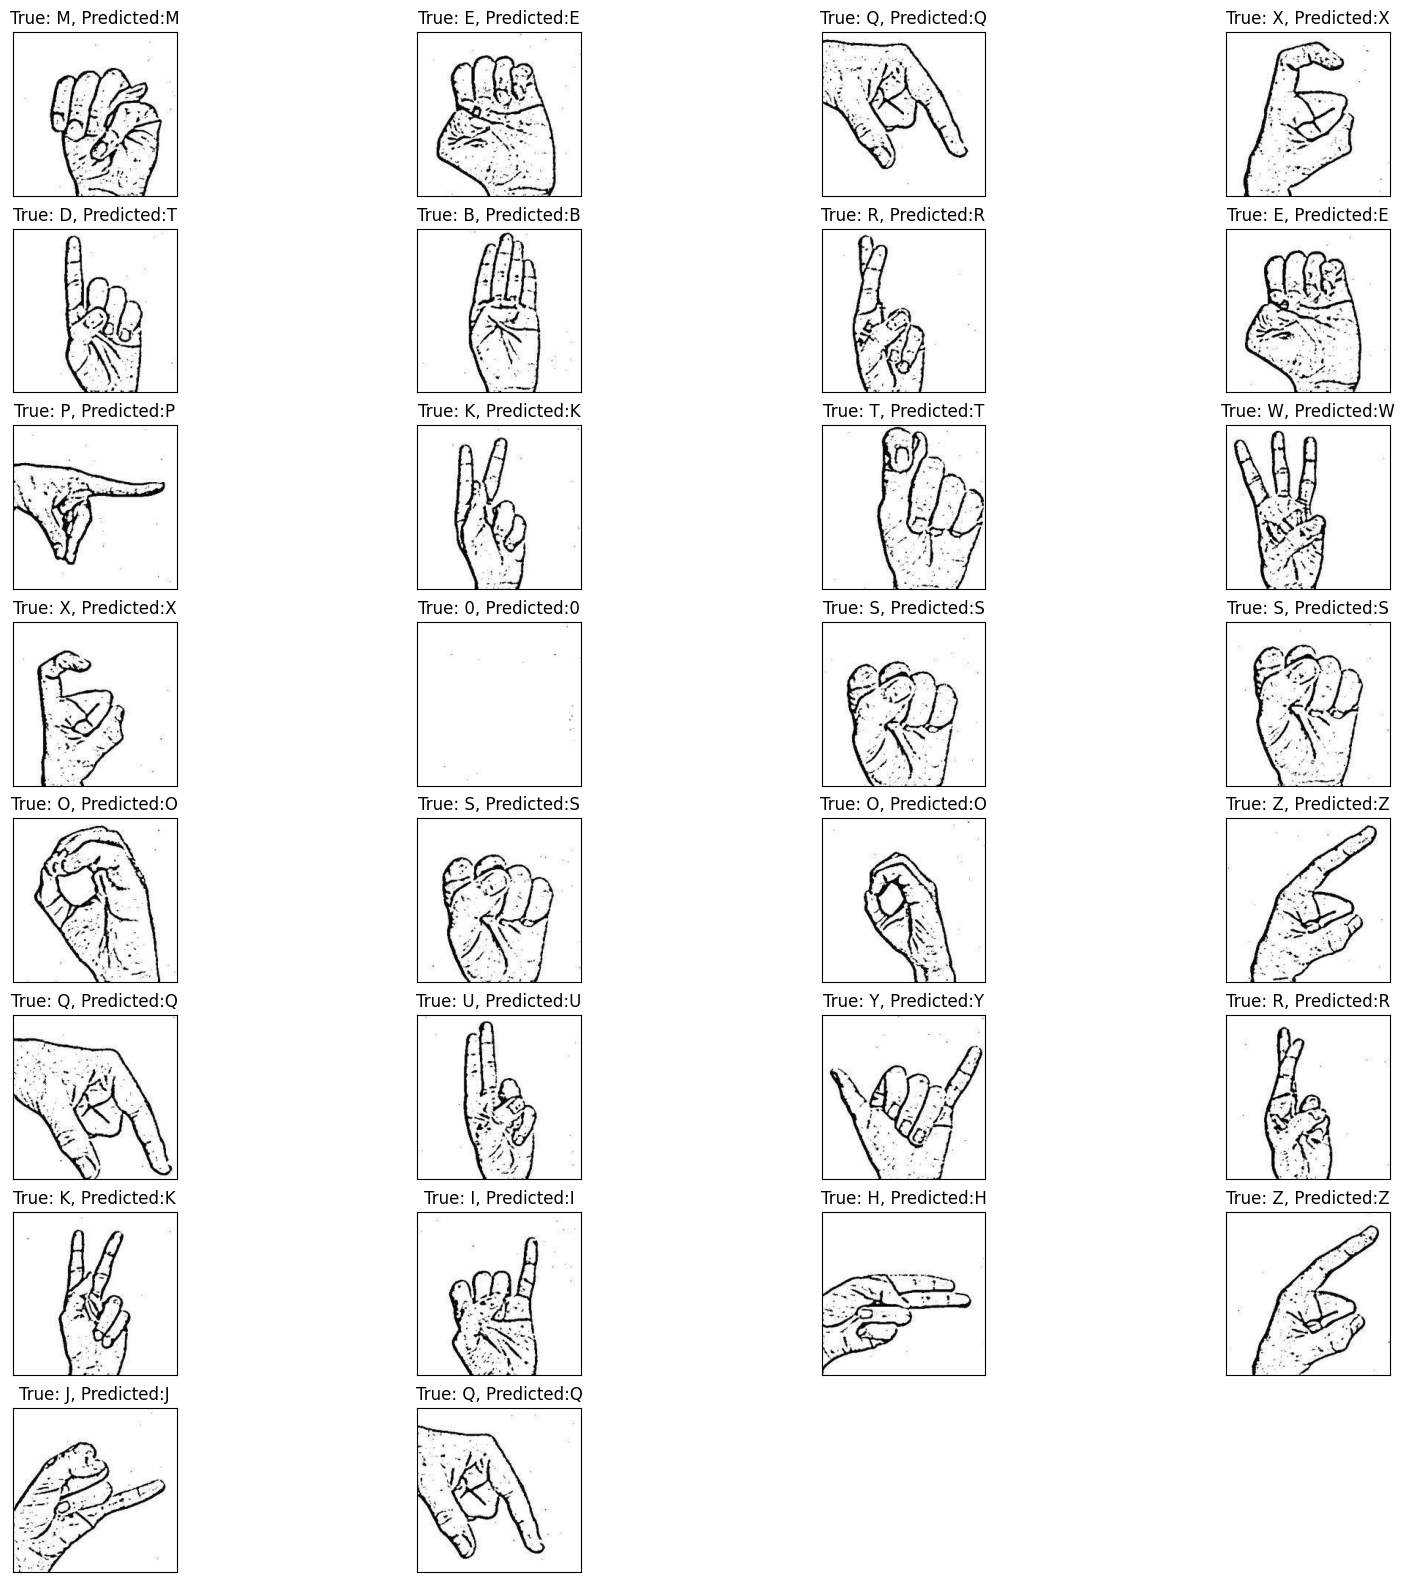

In [30]:
prefix = "/content/drive/MyDrive/sign_language_dataset/test"

classes = os.listdir(prefix)

choices = []

for i in range(6):
  temp = {}
  for j in range(5):
    ch = random.choice(classes)
    li = os.listdir(prefix+"/"+ch)
    file_ = prefix+"/"+ch+"/"+random.choice(li)
    temp[file_] = ch
  choices.append(temp)

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20, 20))
n = 4
im = 8
ct = 1
for row in choices:
  for i in row:
    ax = plt.subplot(im, n, ct)
    ct = ct + 1
    image =  cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    image = np.expand_dims(image, 0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("True: {}, Predicted:{}".format(row[i], train_ds.class_names[np.argmax(model.predict(image)[0])]))
plt.show()

## Loading Model

In [23]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/sign_language_dataset/model.h5')

1/1 [==============================] - 0s 22ms/step


'Q'

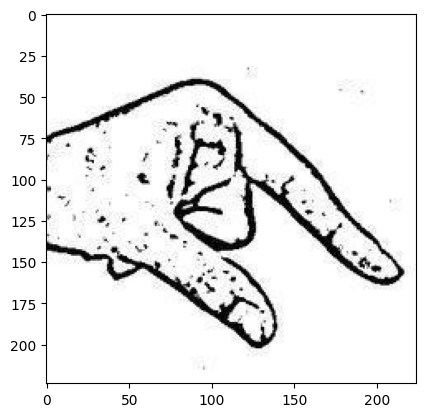

In [29]:
img = cv2.imread("/content/drive/MyDrive/sign_language_dataset/test/Q/602.jpg")
import matplotlib.pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = np.expand_dims(img, 0)
pred = model.predict(img)
train_ds.class_names[np.argmax(pred[0])]